# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [ ]:
from google.colab import files
files.upload()

Saving get_dataset.py to get_dataset.py


{'get_dataset.py': b'import numpy as np\nimport os\nfrom scipy.misc import imread,imresize\nimport pandas as pd\n\ndef fetch_dataset(attrs_name = "lfw_attributes.txt",\n                      images_name = "lfw-deepfunneled",\n                      dx=80,dy=80,\n                      dimx=45,dimy=45\n    ):\n\n    #download if not exists\n    if not os.path.exists(images_name):\n        print("images not found, donwloading...")\n        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")\n        print("extracting...")\n        os.system("tar xvzf tmp.tgz && rm tmp.tgz")\n        print("done")\n        assert os.path.exists(images_name)\n\n    if not os.path.exists(attrs_name):\n        print("attributes not found, downloading...")\n        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)\n        print("done")\n\n    #read attrs\n    df_attrs = pd.read_csv("lfw_attributes.txt",sep=\'\\t\',skiprows=1,) \n    df_att

In [ ]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from tqdm import tqdm

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
# у нас цветные изображения
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE

In [ ]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')
       
DEVICE = torch.device('cuda' if train_on_gpu else 'cpu')

Training on GPU.



Разбейте выборку картинок на train и val:

In [ ]:
X_train = data[:TRAIN_SIZE]
X_val = data[TRAIN_SIZE:VAL_SIZE+TRAIN_SIZE]

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

In [ ]:
def plot_samples(sam1, sam2):
    sam1 = sam1[0].cpu().detach().numpy()
    sam2 = sam2[0].cpu().detach().numpy()
   
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    axes[0].imshow(np.rollaxis(sam1, 0, 3))
    axes[1].imshow(np.rollaxis(sam2, 0, 3))
    fig.tight_layout()

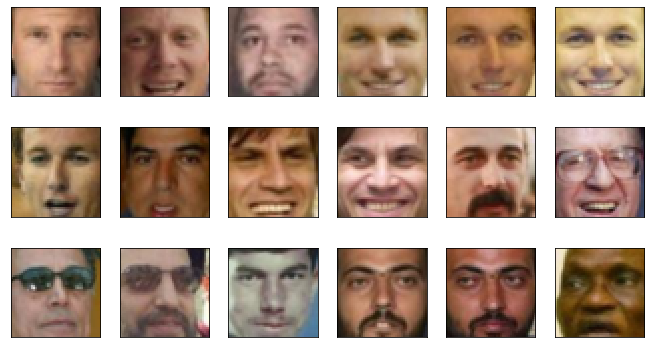

In [ ]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

In [ ]:
X_train = torch.FloatTensor(np.rollaxis(X_train, 3, 1) / 255)
X_val = torch.FloatTensor(np.rollaxis(X_val, 3, 1) / 255)

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [ ]:
inp_size=X_train.shape[1]
dim_code = 100 # размер латентного вектора, т.е. code

In [ ]:
X_train.shape

torch.Size([10000, 3, 45, 45])

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=7, padding=1) # 40x40
        self.bn0 = nn.BatchNorm2d(8)
        self.pl0 = nn.MaxPool2d(2)
        
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5) # 16x16
        self.bn1 = nn.BatchNorm2d(16)
        self.pl1 = nn.MaxPool2d(2)
        
        self.deconv0 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=5, stride=2, output_padding=1) # 20x20
        self.bn2 = nn.BatchNorm2d(8)
        
        self.deconv1 = nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=7, stride=2) # 45x45
        self.bn3 = nn.BatchNorm2d(3)
        
    def forward(self, x, encoder=False, decoder=False):
        if not decoder:
            downconv0 = F.relu(self.conv0(x))
            downbn0 = self.bn0(downconv0)
            downpl0 = self.pl0(downbn0)

            downconv1 = F.relu(self.conv1(downpl0))
            downbn1 = self.bn1(downconv1)
            downpl1 = self.pl1(downbn1)

            latent_code = downpl1
            if encoder:
                return _, latent_code
        else:
            latent_code = x
        
        updeconv0 = F.relu(self.deconv0(latent_code))
        upbn0 = self.bn2(updeconv0)
        
        updeconv1 = F.relu(self.deconv1(upbn0))
        
        reconstruction = updeconv1
        
        return reconstruction, latent_code

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
def train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    for train_x in train_loader:
        train_x = train_x.to(DEVICE)

        # zero  gradients
        optimizer.zero_grad()

        # get the output from the model
        pred_x, code = net(train_x)
        
        # calculate loss
        
        loss = loss_fn(pred_x, train_x)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item() 
        counter += 1
    train_ep_loss /= counter

   
    return train_ep_loss

In [ ]:
def val_epoch(net, val_loader, loss_fn):
    net.eval()
    val_ep_loss = 0.
    counter = 0.
    for val_x in val_loader:
        # get the output from the model
        val_x = val_x.to(DEVICE)
        pred_x, code = net(val_x)

        # calculate loss
        loss = loss_fn(pred_x, val_x)
        val_ep_loss += loss.item() 
        
        counter += 1

    val_ep_loss /= counter
    plot_samples(val_x, pred_x)
    
    return val_ep_loss

In [ ]:
def train(net, train_loader, val_loader, loss_fn, optimizer, epochs, scheduler=None):
    
    train_losses = []
    val_losses = []

    for e in tqdm(range(epochs)):

        train_loss = train_epoch(net, train_loader, loss_fn, optimizer)
        if scheduler:
            scheduler.step()
        with torch.no_grad():
            val_loss = val_epoch(net, val_loader, loss_fn)

        train_losses.append(train_loss)
        val_losses.append(val_loss)


        print("Epoch: {}/{}...".format(e+1, epochs),
                      "Loss: {:.6f}...".format(train_loss),
                      "Val Loss: {:.6f}".format(val_loss))
    return train_losses, val_losses

In [ ]:
batch_size = 64

In [ ]:
train_loader = data_utils.DataLoader(X_train, batch_size=64, shuffle = True, num_workers=4)
val_loader = data_utils.DataLoader(X_val, batch_size=64, shuffle=False, num_workers=4)

In [ ]:
autoencoder = Autoencoder().to(DEVICE)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.2)
criterion = nn.MSELoss()

  3%|▎         | 1/30 [00:02<01:11,  2.47s/it]

Epoch: 1/30... Loss: 0.026162... Val Loss: 0.016669


  7%|▋         | 2/30 [00:04<01:07,  2.41s/it]

Epoch: 2/30... Loss: 0.011644... Val Loss: 0.010189


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 10%|█         | 3/30 [00:06<01:03,  2.36s/it]

Epoch: 3/30... Loss: 0.008914... Val Loss: 0.009721


 13%|█▎        | 4/30 [00:09<01:00,  2.33s/it]

Epoch: 4/30... Loss: 0.008067... Val Loss: 0.007614


 17%|█▋        | 5/30 [00:11<00:58,  2.32s/it]

Epoch: 5/30... Loss: 0.007658... Val Loss: 0.007931


 20%|██        | 6/30 [00:13<00:55,  2.30s/it]

Epoch: 6/30... Loss: 0.007390... Val Loss: 0.007669


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 23%|██▎       | 7/30 [00:16<00:52,  2.29s/it]

Epoch: 7/30... Loss: 0.007292... Val Loss: 0.007735


 27%|██▋       | 8/30 [00:18<00:50,  2.27s/it]

Epoch: 8/30... Loss: 0.007258... Val Loss: 0.007535


 30%|███       | 9/30 [00:20<00:47,  2.26s/it]

Epoch: 9/30... Loss: 0.006946... Val Loss: 0.006745


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 33%|███▎      | 10/30 [00:22<00:45,  2.26s/it]

Epoch: 10/30... Loss: 0.007001... Val Loss: 0.008112


 37%|███▋      | 11/30 [00:25<00:42,  2.25s/it]

Epoch: 11/30... Loss: 0.006933... Val Loss: 0.006625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 40%|████      | 12/30 [00:27<00:40,  2.25s/it]

Epoch: 12/30... Loss: 0.006968... Val Loss: 0.006793


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 43%|████▎     | 13/30 [00:29<00:38,  2.25s/it]

Epoch: 13/30... Loss: 0.006771... Val Loss: 0.006418


 47%|████▋     | 14/30 [00:31<00:36,  2.25s/it]

Epoch: 14/30... Loss: 0.006821... Val Loss: 0.006583


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 50%|█████     | 15/30 [00:34<00:33,  2.25s/it]

Epoch: 15/30... Loss: 0.006648... Val Loss: 0.006729


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 53%|█████▎    | 16/30 [00:36<00:31,  2.25s/it]

Epoch: 16/30... Loss: 0.007127... Val Loss: 0.009922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 57%|█████▋    | 17/30 [00:38<00:29,  2.25s/it]

Epoch: 17/30... Loss: 0.006882... Val Loss: 0.006525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 60%|██████    | 18/30 [00:40<00:26,  2.24s/it]

Epoch: 18/30... Loss: 0.006811... Val Loss: 0.006792


 63%|██████▎   | 19/30 [00:42<00:24,  2.24s/it]

Epoch: 19/30... Loss: 0.006571... Val Loss: 0.007519


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 67%|██████▋   | 20/30 [00:45<00:22,  2.24s/it]

Epoch: 20/30... Loss: 0.006509... Val Loss: 0.006557


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 70%|███████   | 21/30 [00:47<00:20,  2.25s/it]

Epoch: 21/30... Loss: 0.006567... Val Loss: 0.006474


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 73%|███████▎  | 22/30 [00:49<00:17,  2.25s/it]

Epoch: 22/30... Loss: 0.006691... Val Loss: 0.006872


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 77%|███████▋  | 23/30 [00:52<00:15,  2.27s/it]

Epoch: 23/30... Loss: 0.006568... Val Loss: 0.006509


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 80%|████████  | 24/30 [00:54<00:13,  2.27s/it]

Epoch: 24/30... Loss: 0.006660... Val Loss: 0.006364


 83%|████████▎ | 25/30 [00:56<00:11,  2.26s/it]

Epoch: 25/30... Loss: 0.006527... Val Loss: 0.007047


 87%|████████▋ | 26/30 [00:58<00:09,  2.25s/it]

Epoch: 26/30... Loss: 0.006570... Val Loss: 0.006183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 90%|█████████ | 27/30 [01:01<00:06,  2.25s/it]

Epoch: 27/30... Loss: 0.006500... Val Loss: 0.006691


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 93%|█████████▎| 28/30 [01:03<00:04,  2.25s/it]

Epoch: 28/30... Loss: 0.006432... Val Loss: 0.006134


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 97%|█████████▋| 29/30 [01:05<00:02,  2.25s/it]

Epoch: 29/30... Loss: 0.006437... Val Loss: 0.006323


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 30/30 [01:07<00:00,  2.26s/it]


Epoch: 30/30... Loss: 0.006477... Val Loss: 0.006301


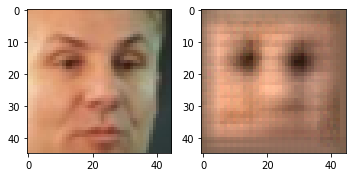

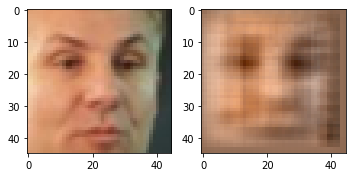

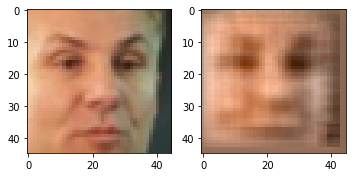

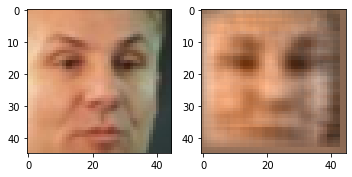

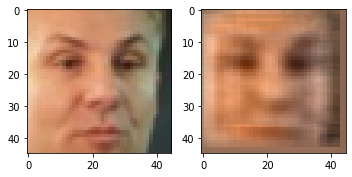

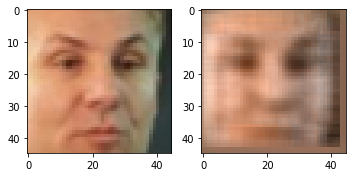

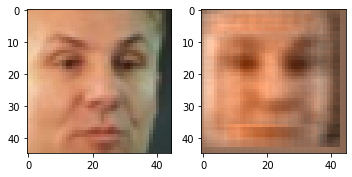

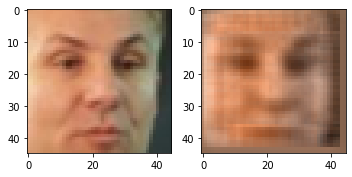

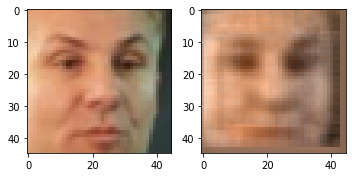

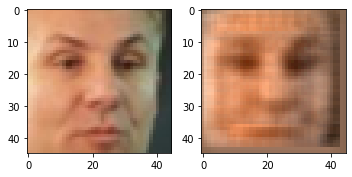

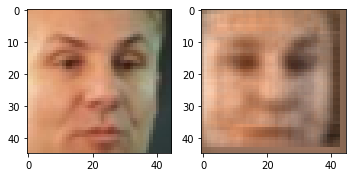

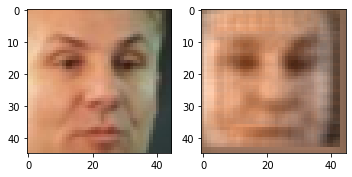

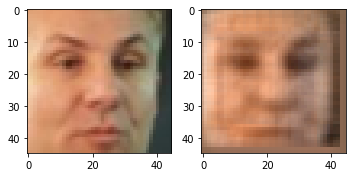

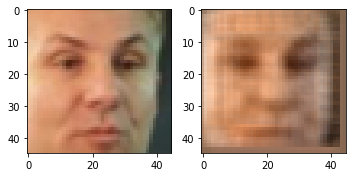

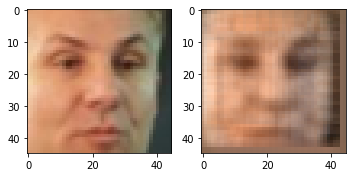

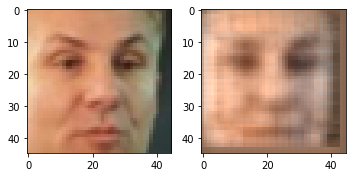

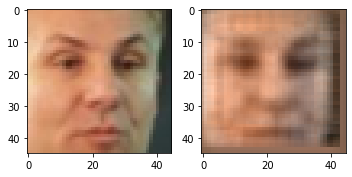

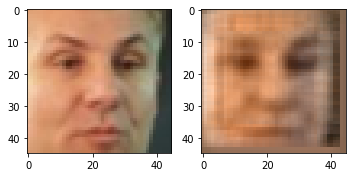

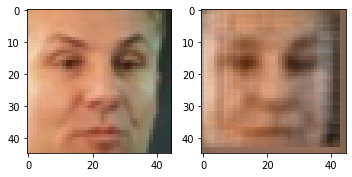

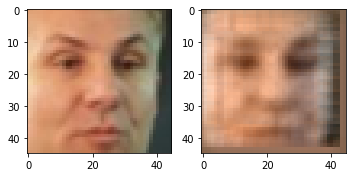

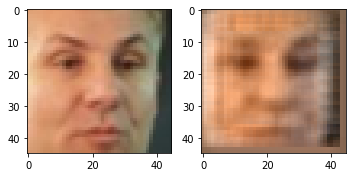

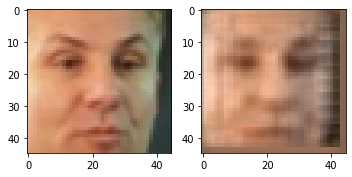

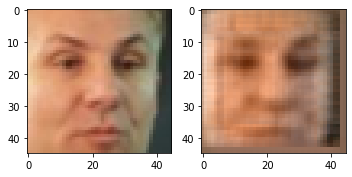

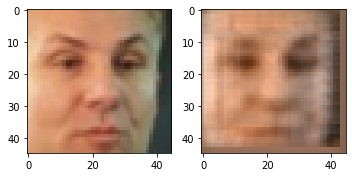

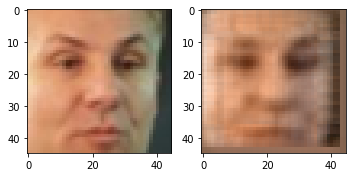

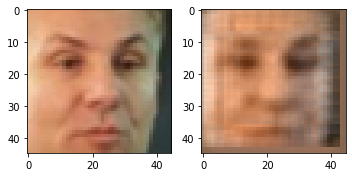

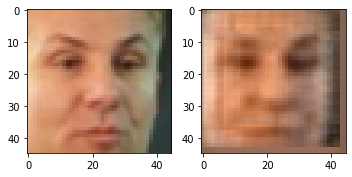

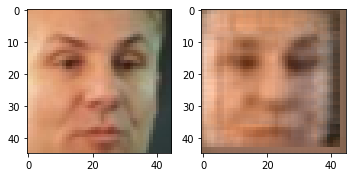

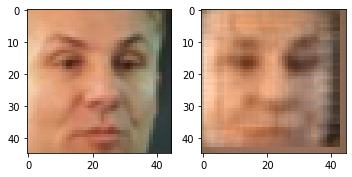

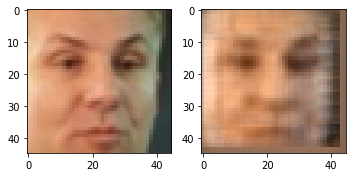

In [ ]:
ae_train_losses, ae_val_losses = train(autoencoder, train_loader, val_loader, criterion, optimizer, 30, scheduler)

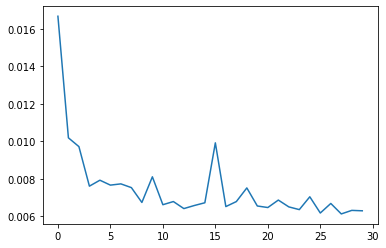

In [ ]:
plt.plot(ae_val_losses)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


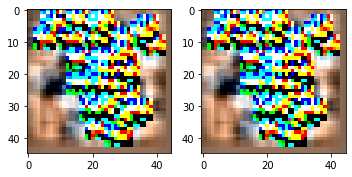

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, 16, 8, 8)
z = torch.FloatTensor(z).to(DEVICE)
output, _ = autoencoder(z, decoder=True)
plot_samples(output, output)

Получить хорошую генерацию лица у меня не получилось, но я сделал "среднее лицо"

In [ ]:
mean_val_loader =  data_utils.DataLoader(X_val, batch_size=1, shuffle=False, num_workers=4)
_, mean_code = autoencoder(iter(mean_val_loader).next().to(DEVICE))
for ex in mean_val_loader:
    _, t = autoencoder(ex.to(DEVICE))
    mean_code += t
mean_code /= VAL_SIZE

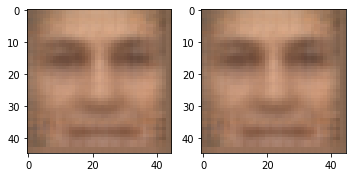

In [ ]:
output, _ = autoencoder(mean_code, decoder=True)
plot_samples(output, output)

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
smiling_numbers = [n for n, x in attrs.iterrows() if x['Smiling'] > 1][:15] 

In [ ]:
smiling_numbers

[5, 8, 9, 11, 26, 34, 60, 83, 88, 96, 101, 106, 108, 132, 135]

In [ ]:
no_smiling_numbers = [n for n, x in attrs.iterrows() if x['Smiling'] < -1][:15] 

In [ ]:
no_smiling_numbers

[6, 10, 17, 22, 48, 49, 50, 53, 55, 56, 62, 63, 70, 71, 74]

In [ ]:
smiling_tensors = X_train[smiling_numbers].to(DEVICE)
no_smiling_tensors = X_train[no_smiling_numbers].to(DEVICE)

In [ ]:
_, smiling_code = autoencoder(smiling_tensors, encoder=True)
_, no_smiling_code = autoencoder(no_smiling_tensors, encoder=True)

In [ ]:
smiling_code_mean = torch.mean(smiling_code, dim=0)
no_smiling_code_mean = torch.mean(no_smiling_code, dim=0)

In [ ]:
smile_code = smiling_code_mean - no_smiling_code_mean

In [ ]:
smile_code = smile_code.unsqueeze(0)

In [ ]:
# sad_man = X_train[min(no_smiling_numbers)]
sad_man = no_smiling_tensors[3]
sad_man = sad_man.unsqueeze(0)

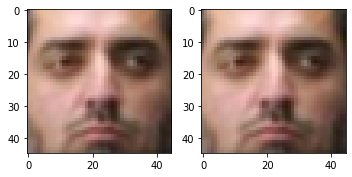

In [ ]:
plot_samples(sad_man, sad_man)

In [ ]:
_, sad_man_code = autoencoder(sad_man, encoder=True)
smiling_man_code = sad_man_code + smile_code
smiling_man, _ = autoencoder(smiling_man_code, decoder=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


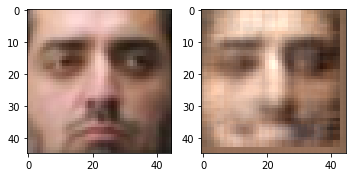

In [ ]:
plot_samples(sad_man, smiling_man)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (2 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.eps = 1e-8
        
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=7, padding=1) # 24x24
        self.bn0 = nn.BatchNorm2d(8)
        self.pl0 = nn.MaxPool2d(2)
        
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5) # 8x8
        self.bn1 = nn.BatchNorm2d(32)
        self.pl1 = nn.MaxPool2d(2)
        
        self.deconv0 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=5, stride=2, output_padding=1) # 12x12
        self.bn2 = nn.BatchNorm2d(8)
        
        self.deconv1 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=7, stride=2, padding=1, output_padding=1) # 28x28
        self.bn3 = nn.BatchNorm2d(3)

    def encode(self, x):
        downconv0 = F.relu(self.conv0(x))
        downbn0 = self.bn0(downconv0)
        downpl0 = self.pl0(downbn0)

        downconv1 = F.relu(self.conv1(downpl0))
#         downbn1 = self.bn1(downconv1)
        downpl1 = self.pl1(downconv1)

        mu = downpl1[:, :16, ...]
        logsigma = torch.log_(downpl1[:, 16:, ...] + self.eps)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        updeconv0 = F.relu(self.deconv0(z))
        upbn0 = self.bn2(updeconv0)
        
        updeconv1 = F.sigmoid(self.deconv1(upbn0))
        reconstruction = updeconv1
        
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(sample)
        
        return mu, logsigma, reconstruction

In [ ]:
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
        self.begin_encoder = nn.Sequential(
            nn.Linear(28 * 28 * 1, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
        )
        self.latent1 = nn.Linear(250, dim_code)
        self.latent2 = nn.Linear(250, dim_code)
        self.begin_decoder = nn.Sequential(
            nn.Linear(dim_code, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
        )
        self.out = nn.Sequential(
            nn.Linear(500, 28 * 28 * 1),
            nn.Sigmoid(),
        )
 
    def encode(self, x):
        x = self.begin_encoder(x)
        mu = self.latent1(x)
        logsigma = self.latent2(x)
        return mu, logsigma
   
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp()
            eps = torch.randn_like(std)
            return eps.mul(std).add(mu)
        else:
            return mu
   
    def decode(self, z):
        z = self.begin_decoder(z)
        reconstruction = self.out(z)
        return reconstruction
 
    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + 2 * logsigma - mu * mu - torch.exp(2 * logsigma))
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss()
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    c = x.size(0) * x.size(1)
    return KL_divergence(mu, logsigma) / c + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
def plot_mnist(sam1, sam2):
    sam1 = sam1.cpu().detach().numpy()
    sam2 = sam2.cpu().detach().numpy()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    axes[0].imshow(sam1.reshape(28,28))
    axes[1].imshow(sam2.reshape(28,28))
    fig.tight_layout()

In [ ]:
vae = LinearVAE().to(DEVICE)

optimizer = torch.optim.Adam(vae.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.2)
criterion = loss_vae

In [ ]:
mnist_train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=16, shuffle=True)

mnist_val_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=16, shuffle=False)

Extracting files/MNIST/raw/train-images-idx3-ubyte.gz to files/MNIST/raw


Extracting files/MNIST/raw/train-labels-idx1-ubyte.gz to files/MNIST/raw



Extracting files/MNIST/raw/t10k-images-idx3-ubyte.gz to files/MNIST/raw


Extracting files/MNIST/raw/t10k-labels-idx1-ubyte.gz to files/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
def mnist_train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    for train_x in train_loader:
        train_x = train_x[0].to(DEVICE)
        train_x = train_x.view(-1, 28 * 28)
        # zero  gradients
        optimizer.zero_grad()

        # get the output from the model
        mu, logsigma, reconstruction = net(train_x)
        
        # calculate loss
        
        loss = loss_fn(train_x, mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item() 
        counter += 1
    train_ep_loss /= counter
   
    return train_ep_loss

In [ ]:
def mnist_val_epoch(net, val_loader, loss_fn):
    net.eval()
    val_ep_loss = 0.
    counter = 0.
    for val_x in val_loader:
        # get the output from the model
        val_x = val_x[0].to(DEVICE)
        val_x = val_x.view(-1, 28 * 28)

        mu, logsigma, reconstruction = net(val_x)
        
        # calculate loss
        
        loss = loss_fn(val_x, mu, logsigma, reconstruction)
        val_ep_loss += loss.item() 
        
        counter += 1

    val_ep_loss /= counter
    rand = np.random.randint(16)
    plot_mnist(val_x[rand], reconstruction[rand])
    
    return val_ep_loss

In [ ]:
def mnist_train(net, train_loader, val_loader, loss_fn, optimizer, epochs, scheduler=None):
    
    train_losses = []
    val_losses = []

    for e in tqdm(range(epochs)):

        train_loss = mnist_train_epoch(net, train_loader, loss_fn, optimizer)
        if scheduler:
            scheduler.step()
        with torch.no_grad():
            val_loss = mnist_val_epoch(net, val_loader, loss_fn)

        train_losses.append(train_loss)
        val_losses.append(val_loss)


        print("Epoch: {}/{}...".format(e+1, epochs),
                      "Loss: {:.6f}...".format(train_loss),
                      "Val Loss: {:.6f}".format(val_loss))
    return train_losses, val_losses






  0%|          | 0/20 [00:00<?, ?it/s]




  5%|▌         | 1/20 [00:18<05:49, 18.39s/it]

Epoch: 1/20... Loss: 0.235961... Val Loss: 0.231453







 10%|█         | 2/20 [00:36<05:31, 18.40s/it]

Epoch: 2/20... Loss: 0.225420... Val Loss: 0.224166







 15%|█▌        | 3/20 [00:55<05:14, 18.47s/it]

Epoch: 3/20... Loss: 0.223308... Val Loss: 0.221620







 20%|██        | 4/20 [01:13<04:53, 18.36s/it]

Epoch: 4/20... Loss: 0.222663... Val Loss: 0.220175







 25%|██▌       | 5/20 [01:32<04:35, 18.40s/it]

Epoch: 5/20... Loss: 0.221652... Val Loss: 0.217871







 30%|███       | 6/20 [01:50<04:18, 18.43s/it]

Epoch: 6/20... Loss: 0.221290... Val Loss: 0.218650







 35%|███▌      | 7/20 [02:09<04:00, 18.53s/it]

Epoch: 7/20... Loss: 0.221434... Val Loss: 0.217886







 40%|████      | 8/20 [02:27<03:41, 18.47s/it]

Epoch: 8/20... Loss: 0.221258... Val Loss: 0.218313







 45%|████▌     | 9/20 [02:45<03:22, 18.39s/it]

Epoch: 9/20... Loss: 0.221372... Val Loss: 0.216349







 50%|█████     | 10/20 [03:04<03:05, 18.55s/it]

Epoch: 10/20... Loss: 0.220247... Val Loss: 0.224044







 55%|█████▌    | 11/20 [03:23<02:47, 18.61s/it]

Epoch: 11/20... Loss: 0.219760... Val Loss: 0.216148







 60%|██████    | 12/20 [03:41<02:27, 18.46s/it]

Epoch: 12/20... Loss: 0.219763... Val Loss: 0.216234







 65%|██████▌   | 13/20 [04:00<02:09, 18.46s/it]

Epoch: 13/20... Loss: 0.219631... Val Loss: 0.217945







 70%|███████   | 14/20 [04:17<01:49, 18.27s/it]

Epoch: 14/20... Loss: 0.219457... Val Loss: 0.218592







 75%|███████▌  | 15/20 [04:36<01:31, 18.32s/it]

Epoch: 15/20... Loss: 0.218794... Val Loss: 0.215247







 80%|████████  | 16/20 [04:54<01:13, 18.42s/it]

Epoch: 16/20... Loss: 0.219210... Val Loss: 0.214011







 85%|████████▌ | 17/20 [05:13<00:55, 18.53s/it]

Epoch: 17/20... Loss: 0.218397... Val Loss: 0.213269







 90%|█████████ | 18/20 [05:32<00:37, 18.59s/it]

Epoch: 18/20... Loss: 0.217968... Val Loss: 0.216045







 95%|█████████▌| 19/20 [05:50<00:18, 18.55s/it]

Epoch: 19/20... Loss: 0.217950... Val Loss: 0.236417







100%|██████████| 20/20 [06:09<00:00, 18.48s/it]

Epoch: 20/20... Loss: 0.218123... Val Loss: 0.216837


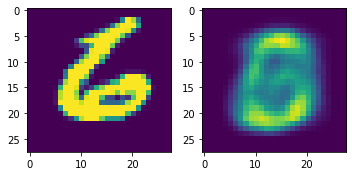

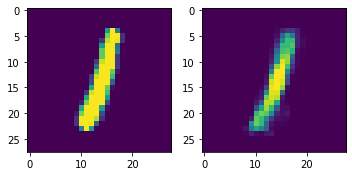

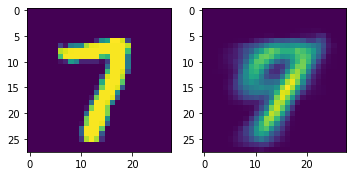

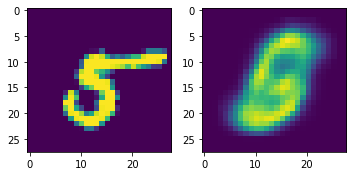

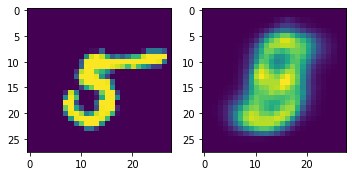

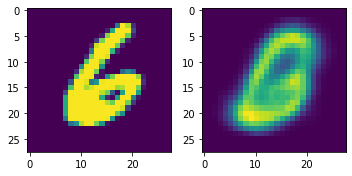

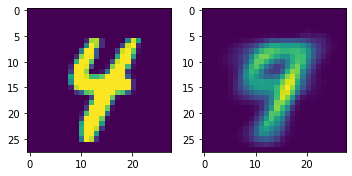

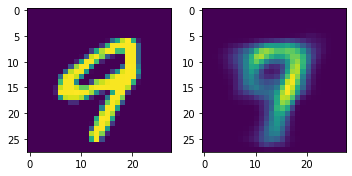

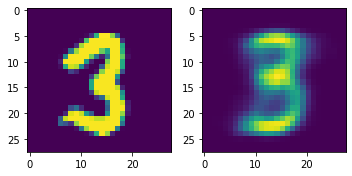

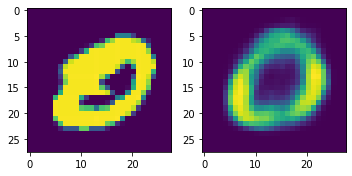

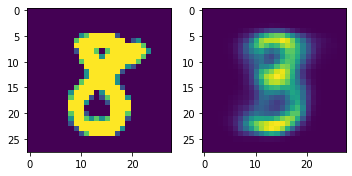

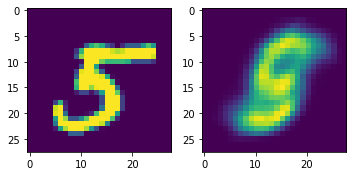

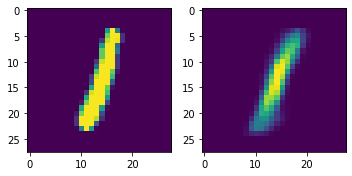

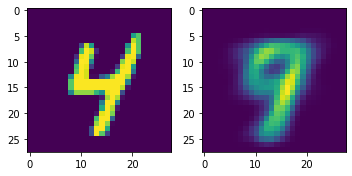

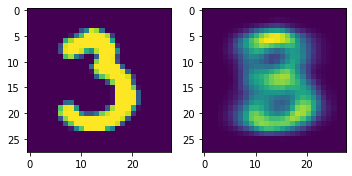

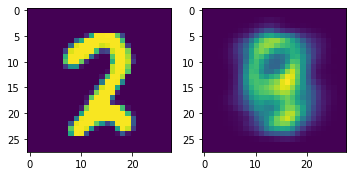

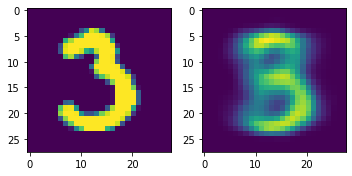

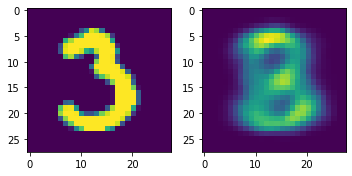

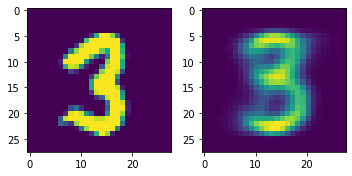

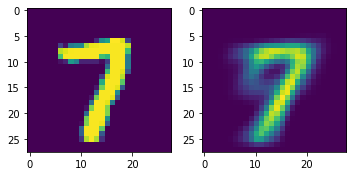

In [ ]:
vae_train_losses, vae_val_losses = mnist_train(vae, mnist_train_loader, mnist_val_loader, criterion, optimizer, 20, scheduler)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
def plot_10(output, data):
    output = output.cpu().detach().numpy()
    data = data.cpu().detach().numpy()

    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 3))
    for ii, ax in enumerate(axes[0].flatten()):
        ax.imshow(data[ii].reshape(28,28))

    for ii, ax in enumerate(axes[1].flatten()):
        ax.imshow(output[ii].reshape(28,28))
    fig.tight_layout()

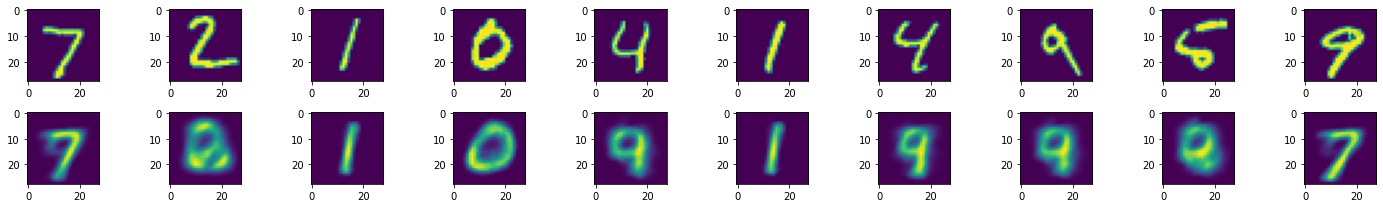

In [ ]:
mnist_val_10 = iter(mnist_val_loader).next()[0]
_, _, output = vae(mnist_val_10[:10, ...].to(DEVICE).view(-1, 28*28))
plot_10(output, mnist_val_10)

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.random.normal(0, 1, size=(10, 100))
z = torch.FloatTensor(z).to(DEVICE)
output = vae.decode(z)
# plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=2, n_col=5)

In [ ]:
output.shape

torch.Size([10, 784])

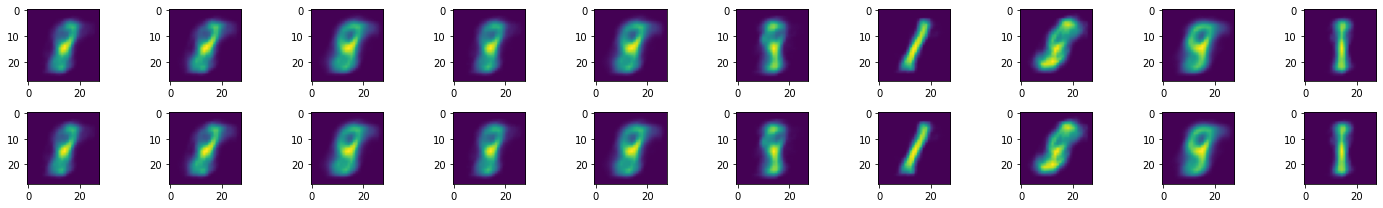

In [ ]:
plot_10(output, output)

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [ ]:
import gc
gc.collect()

22

(3143, 2)


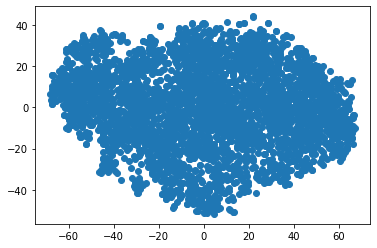

In [ ]:
_, ae_output = autoencoder(X_val.to(DEVICE), encoder=True)
ae_output = ae_output.reshape(3143, -1)
ae_output = ae_output.cpu().detach().numpy()

from sklearn.manifold import TSNE
X_embedded = TSNE().fit_transform(ae_output)
print(X_embedded.shape)

plt.figure()
x, y = np.hsplit(X_embedded, 2)
plt.scatter(x, y)

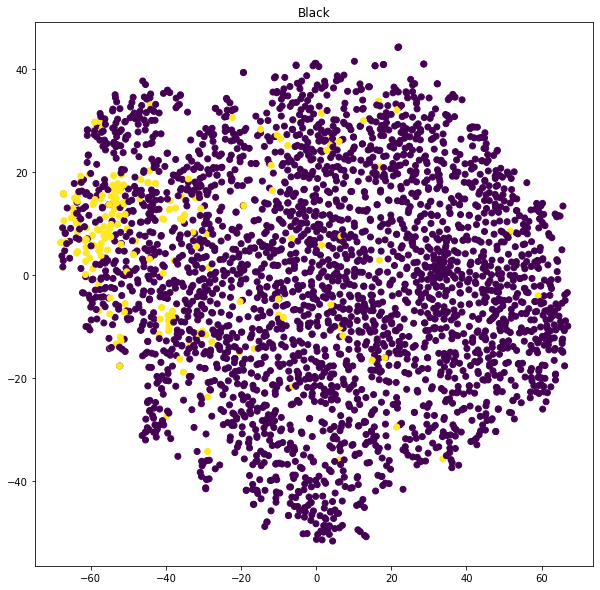

In [ ]:
x_black = [1 if x > 0 else 0 for x in attrs['Black']]
val_black = x_black[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE]
f = plt.figure(figsize=(10,10))
x, y = np.hsplit(X_embedded, 2)
plt.scatter(x, y, c=val_black)
plt.title('Black')
plt.show()

Что вы думаете о виде латентного представления?

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [ ]:
one_hot_digits_features = []
for i in range(10):
    digit = [i, i]
    one_hot_digits_features.append(digit)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_digits = OneHotEncoder().fit(one_hot_digits_features)
one_hot_digits.transform(one_hot_digits_features).toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.]])

In [ ]:
one_hot_digits = torch.FloatTensor(one_hot_digits.transform(one_hot_digits_features).toarray()).to(DEVICE)

In [ ]:
class CVAE(nn.Module):
    def __init__(self, one_hot_digits):
        super(CVAE, self).__init__()
        self.one_hot_digits = one_hot_digits
        self.num_digits = 2 * 10
        self.begin_encoder = nn.Sequential(
            nn.Linear(28 * 28 * 1  + self.num_digits, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
        )
        self.latent1 = nn.Linear(250, dim_code)
        self.latent2 = nn.Linear(250, dim_code)
        self.begin_decoder = nn.Sequential(
            nn.Linear(dim_code + self.num_digits, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
        )
        self.out = nn.Sequential(
            nn.Linear(500, 28 * 28 * 1),
            nn.Sigmoid(),
        )
 
    def encode(self, x, digit):
        digit = self.one_hot_digits[digit]
        digit = digit.to(DEVICE)
        x = torch.cat([x, digit], 1)
        x = self.begin_encoder(x)
        mu = self.latent1(x)
        logsigma = self.latent2(x)
        return mu, logsigma
   
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp()

            eps = torch.randn_like(std)
            return eps.mul(std).add(mu)
        else:
            return mu
   
    def decode(self, z, digit):
        digit = self.one_hot_digits[digit]
        digit = digit.to(DEVICE)
        z = torch.cat([z, digit], 1)
        z = self.begin_decoder(z)
        reconstruction = self.out(z)
        return reconstruction
 
    def forward(self, x, digit):
        mu, logsigma = self.encode(x, digit)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, digit)
        return mu, logsigma, reconstruction

In [ ]:
mnist_train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=16, shuffle=True)

mnist_val_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=16, shuffle=False)

In [ ]:
def cvae_train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    for train_x in train_loader:
        train_x, digit = train_x
        train_x, digit = train_x.to(DEVICE), digit.to(DEVICE)
        train_x = train_x.view(-1, 28 * 28)
        # zero  gradients
        optimizer.zero_grad()

        # get the output from the model
        mu, logsigma, reconstruction = net(train_x, digit)
        
        # calculate loss
        
        loss = loss_fn(train_x, mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item() 
        counter += 1
    train_ep_loss /= counter
   
    return train_ep_loss

In [ ]:
def cvae_val_epoch(net, val_loader, loss_fn):
    net.eval()
    val_ep_loss = 0.
    counter = 0.
    for val_x in val_loader:
        # get the output from the model
        val_x, digit = val_x
        val_x, digit = val_x.to(DEVICE), digit.to(DEVICE)
        val_x = val_x.view(-1, 28 * 28)

        mu, logsigma, reconstruction = net(val_x, digit)
        
        # calculate loss
        
        loss = loss_fn(val_x, mu, logsigma, reconstruction)
        val_ep_loss += loss.item() 
        
        counter += 1

    val_ep_loss /= counter
    rand = np.random.randint(16)
    plot_mnist(val_x[rand], reconstruction[rand])
    
    return val_ep_loss

In [ ]:
def cvae_train(net, train_loader, val_loader, loss_fn, optimizer, epochs, scheduler=None):
    
    train_losses = []
    val_losses = []

    for e in tqdm(range(epochs)):

        train_loss = cvae_train_epoch(net, train_loader, loss_fn, optimizer)
        if scheduler:
            scheduler.step()
        with torch.no_grad():
            val_loss = cvae_val_epoch(net, val_loader, loss_fn)

        train_losses.append(train_loss)
        val_losses.append(val_loss)


        print("Epoch: {}/{}...".format(e+1, epochs),
                      "Loss: {:.6f}...".format(train_loss),
                      "Val Loss: {:.6f}".format(val_loss))
    return train_losses, val_losses

In [ ]:
cvae = CVAE(one_hot_digits).to(DEVICE)

optimizer = torch.optim.Adam(cvae.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.2)
criterion = loss_vae

  5%|▌         | 1/20 [00:29<09:27, 29.89s/it]

Epoch: 1/20... Loss: 0.213522... Val Loss: 0.204022


 10%|█         | 2/20 [00:59<08:59, 29.95s/it]

Epoch: 2/20... Loss: 0.202500... Val Loss: 0.199220


 15%|█▌        | 3/20 [01:30<08:30, 30.05s/it]

Epoch: 3/20... Loss: 0.200336... Val Loss: 0.196478


 20%|██        | 4/20 [02:00<08:00, 30.06s/it]

Epoch: 4/20... Loss: 0.199490... Val Loss: 0.196406


 25%|██▌       | 5/20 [02:30<07:30, 30.03s/it]

Epoch: 5/20... Loss: 0.198909... Val Loss: 0.195318


 30%|███       | 6/20 [03:00<07:00, 30.07s/it]

Epoch: 6/20... Loss: 0.198881... Val Loss: 0.194353


 35%|███▌      | 7/20 [03:30<06:30, 30.00s/it]

Epoch: 7/20... Loss: 0.198459... Val Loss: 0.196738


 40%|████      | 8/20 [04:00<06:00, 30.02s/it]

Epoch: 8/20... Loss: 0.198090... Val Loss: 0.197573


 45%|████▌     | 9/20 [04:30<05:29, 29.98s/it]

Epoch: 9/20... Loss: 0.198432... Val Loss: 0.196201


 50%|█████     | 10/20 [05:00<05:00, 30.03s/it]

Epoch: 10/20... Loss: 0.198573... Val Loss: 0.194869


 55%|█████▌    | 11/20 [05:30<04:29, 29.99s/it]

Epoch: 11/20... Loss: 0.198883... Val Loss: 0.194973


 60%|██████    | 12/20 [06:00<03:59, 29.97s/it]

Epoch: 12/20... Loss: 0.205633... Val Loss: 0.196400


 65%|██████▌   | 13/20 [06:30<03:30, 30.02s/it]

Epoch: 13/20... Loss: 0.200859... Val Loss: 0.197463


 70%|███████   | 14/20 [07:00<03:00, 30.02s/it]

Epoch: 14/20... Loss: 0.200272... Val Loss: 0.199481


 75%|███████▌  | 15/20 [07:30<02:30, 30.00s/it]

Epoch: 15/20... Loss: 0.198892... Val Loss: 0.196107


 80%|████████  | 16/20 [08:00<02:00, 30.05s/it]

Epoch: 16/20... Loss: 0.200063... Val Loss: 0.197067


 85%|████████▌ | 17/20 [08:30<01:30, 30.08s/it]

Epoch: 17/20... Loss: 0.198461... Val Loss: 0.195531


 90%|█████████ | 18/20 [09:00<01:00, 30.03s/it]

Epoch: 18/20... Loss: 0.198929... Val Loss: 0.201139


 95%|█████████▌| 19/20 [09:30<00:30, 30.01s/it]

Epoch: 19/20... Loss: 0.198757... Val Loss: 0.196752


100%|██████████| 20/20 [10:00<00:00, 30.04s/it]

Epoch: 20/20... Loss: 0.198371... Val Loss: 0.196218


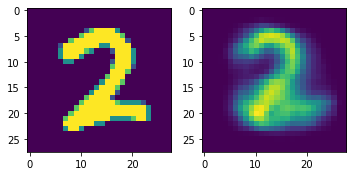

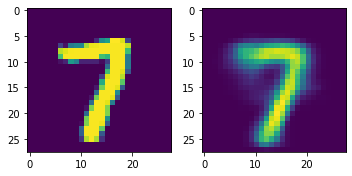

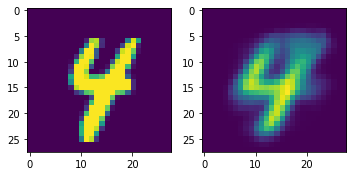

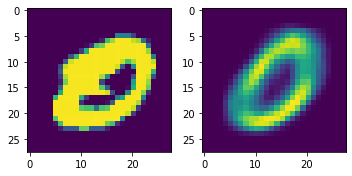

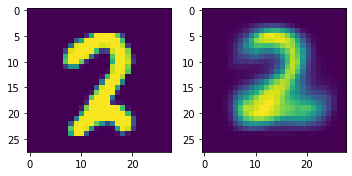

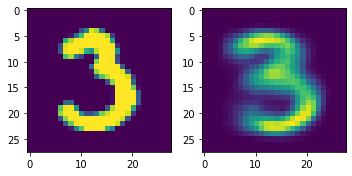

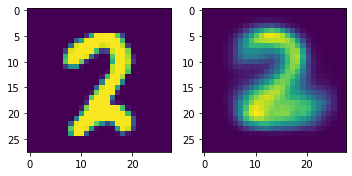

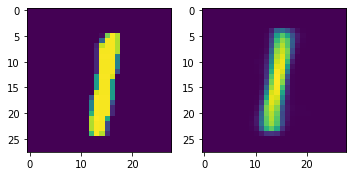

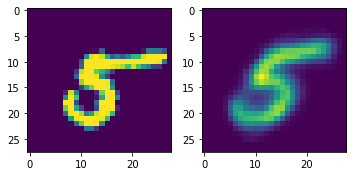

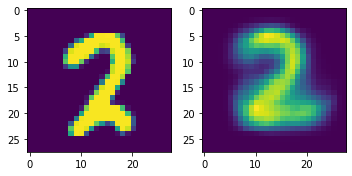

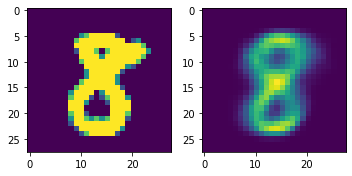

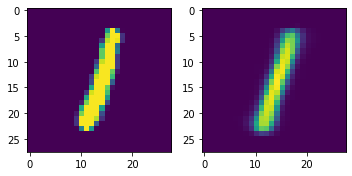

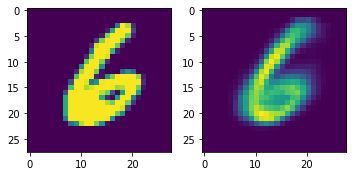

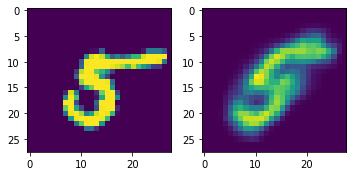

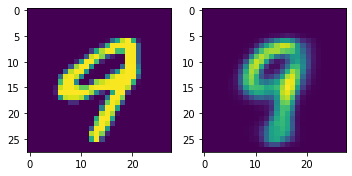

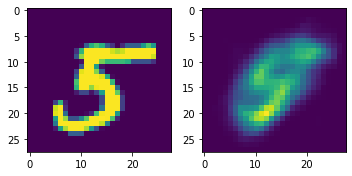

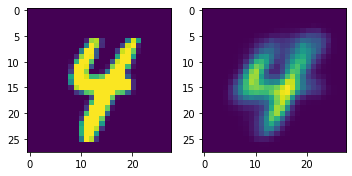

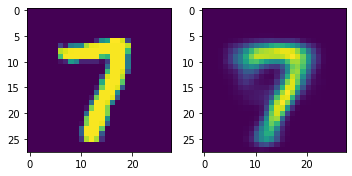

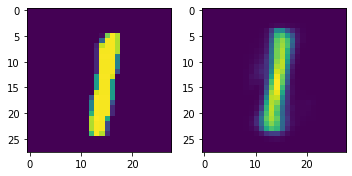

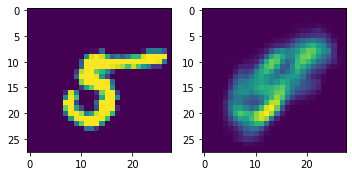

In [ ]:
сvae_train_losses, сvae_val_losses = cvae_train(cvae, mnist_train_loader, mnist_val_loader, criterion, optimizer, 20, scheduler)

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.random.normal(0, 1, size=(10, 100))
z = torch.FloatTensor(z).to(DEVICE)
output = cvae.decode(z, [float(x) for x in range(10)])

In [ ]:
def plot_cvae(data):
    data = data.cpu().detach().numpy()
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6))
    for ii, ax in enumerate(axes.flatten()):
      ax.imshow(data[ii].reshape(28,28))
    fig.tight_layout()

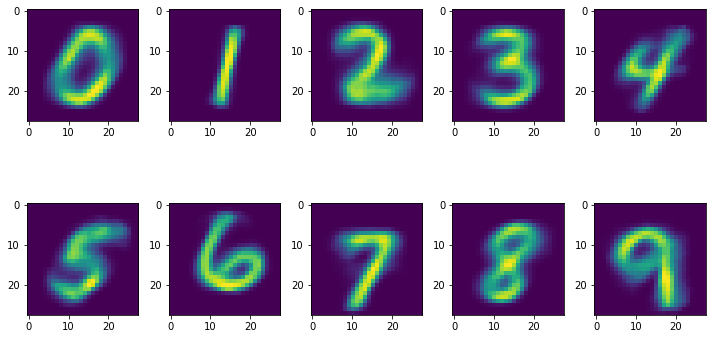

In [ ]:
plot_cvae(output)

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
cvae_latent_mnist = []
cvae_labels = []
for val_x in mnist_val_loader:
    val_x, digit = val_x
    val_x, digit = val_x.to(DEVICE), digit.to(DEVICE)
    val_x = val_x.view(-1, 28 * 28)
    output, _ = cvae.encode(val_x, digit)
    cvae_latent_mnist.extend(output.cpu().detach().numpy())
    cvae_labels.extend(digit.cpu().detach().numpy())

In [ ]:
cvae_latent_mnist = np.array(cvae_latent_mnist)
cvae_labels = np.array(cvae_labels)

(10000, 2)


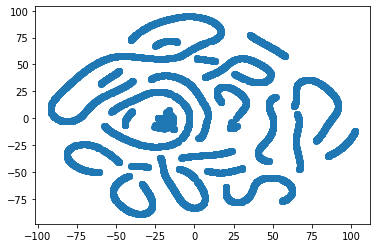

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE().fit_transform(cvae_latent_mnist)
print(X_embedded.shape)

plt.figure()
x, y = np.hsplit(X_embedded, 2)
plt.scatter(x, y)

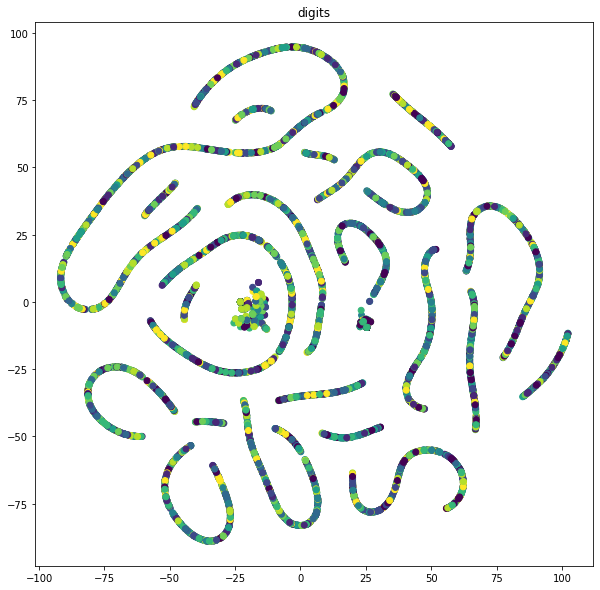

In [ ]:
f = plt.figure(figsize=(10,10))
x, y = np.hsplit(X_embedded, 2)
plt.scatter(x, y, c=cvae_labels)
plt.title('digits')
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

In [ ]:
val_batch = iter(val_loader).next().to(DEVICE)
first_face, second_face = val_batch[0][None, ...], val_batch[1][None, ...]
_, first_face_latent = autoencoder(first_face, encoder=True)
_, second_face_latent = autoencoder(second_face, encoder=True)

In [ ]:
changing_face = []
for i in range(10):
    alpha = i / 10
    current_face = alpha * first_face_latent + (1 - alpha) * second_face_latent
    changing_face.append(autoencoder(current_face, decoder=True)[0])

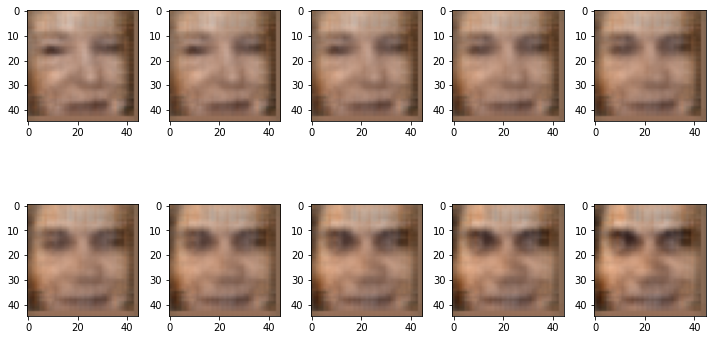

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6))
for ii, ax in enumerate(axes.flatten()):
  ax.imshow(np.rollaxis(changing_face[ii].cpu().detach().numpy()[0], 0, 3))
fig.tight_layout()

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [ ]:
<тут ваш код обучения автоэнкодера на occluded (простите, не знаю, как это сказать по-русски) картинках. Не забудтье разбить на train/test!>

# Bonus 3: Image Retrieval (2 балла)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!